### Regression model

In [1]:
import pandas as pd
import geopandas as gpd
import pickle
from pysal.lib import weights # import weight lib
from sklearn.model_selection import train_test_split
from sklearn import cluster
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import statsmodels.graphics.api as smg
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse
from math import *


In [36]:
with open('NewTotal.pickle', 'rb') as handle:
    all_cities = pickle.load(handle)

In [37]:
#all_cities = pd.concat([RegDf['rotterdam'], RegDf['munich'], RegDf['zurich'], RegDf['frankfurt'], RegDf['hamburg']])
all_cities

,detid,flow,City,geometry,NeighboursTotal,station,cycleway,footway,pedestrian,footwayplatform,Lag_Flow
0,GRT02_MORO_1811_2_1,392.931968,rotterdam,POINT (-409627.897 114878.047),45.0,0,19,24,2,0.0,352.676664
1,GRT02_MORO_1822_2_1,339.342356,rotterdam,POINT (-408094.756 114817.516),17.0,0,9,8,0,0.0,340.167520
2,GRT02_MORO_1293_2_1,385.277249,rotterdam,POINT (-413618.789 120024.077),57.0,0,19,32,6,0.0,307.186174
3,GRT02_MORO_1293_2_2,280.088515,rotterdam,POINT (-413618.789 120024.077),57.0,0,19,32,6,0.0,307.186174
4,GRT02_MORO_1851_2_1,342.891002,rotterdam,POINT (-411548.145 113917.160),16.0,0,4,12,0,0.0,229.296342
...,...,...,...,...,...,...,...,...,...,...,...
2313,STA2_D4(KFZ4),70.794979,frankfurt,POINT (-130952.381 -98513.752),32.0,0,2,30,0,NaN,228.490074
2314,STA1_D1(KFZ4),514.000000,frankfurt,POINT (-130978.227 -98382.916),30.0,0,2,28,0,NaN,199.996146
2315,STA1_D2(KFZ4),576.708333,frankfurt,POINT (-130981.138 -98384.956),30.0,0,2,28,0,NaN,193.725312
2316,STA1_D9(KFZ5),99.855596,frankfurt,POINT (-130941.286 -98365.248),30.0,0,2,28,0,NaN,241.410586


In [38]:
all_cities = all_cities[all_cities['flow'].notna()]

In [39]:
all_cities = all_cities.fillna(0)

In [40]:
all_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2317 entries, 0 to 2317
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   detid            2317 non-null   object  
 1   flow             2317 non-null   float64 
 2   City             2317 non-null   object  
 3   geometry         2317 non-null   geometry
 4   NeighboursTotal  2317 non-null   float64 
 5   station          2317 non-null   int64   
 6   cycleway         2317 non-null   int64   
 7   footway          2317 non-null   int64   
 8   pedestrian       2317 non-null   int64   
 9   footwayplatform  2317 non-null   float64 
 10  Lag_Flow         2317 non-null   float64 
dtypes: float64(4), geometry(1), int64(4), object(2)
memory usage: 217.2+ KB


In [42]:
def regression(y_array, x_array, df):
    
    # the df is split into a training and testing set
    # the test size is 0.2%, since the df is not very large
    traindf, testdf = train_test_split(df, test_size=0.2, random_state=42)
    print(f'Shape of the training set is {traindf.shape} and of the testing set is {testdf.shape}.')

    # creates arrays for the predicted variable and the prediction variables
    y_train = traindf[y_array]
    x_train = traindf[x_array]

    y_test = testdf[y_array]
    x_test = testdf[x_array]
    
    x_train = pd.get_dummies(x_train, columns=['City'])
    x_test = pd.get_dummies(x_test, columns=['City'])
    
    # create the X matrix by appending a column of ones to x_train and x_test
    train_data_augmented = sm.add_constant(x_train)
    test_data_augmented = sm.add_constant(x_test)

    # build the OLS model (ordinary least squares) from the training data
    OLS_model = sm.OLS(y_train, train_data_augmented)

    # do the fit and save regression info (parameters, etc) in OLS_results
    OLS_results = OLS_model.fit()
    
    # get the prediction results for the test set
    predy_test = OLS_results.predict(test_data_augmented)
    
    return [OLS_results, y_train, x_train, y_test, x_test, predy_test]



### First iteration model

In [43]:
regression_model1, y_train1, x_train1, y_test1, x_test1, predy_test1\
= regression(['flow'], ['station', 'cycleway', 'footway', 'pedestrian', 'City', 'footwayplatform'], all_cities )

Shape of the training set is (1853, 11) and of the testing set is (464, 11).


In [44]:
print(regression_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     17.32
Date:                Mon, 09 Nov 2020   Prob (F-statistic):           9.15e-28
Time:                        12:36:53   Log-Likelihood:                -11793.
No. Observations:                1853   AIC:                         2.361e+04
Df Residuals:                    1843   BIC:                         2.366e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             174.9862      5.930     

In [45]:
all_cities['residues'] = regression_model1.resid # get residues on train set
OLS1 = all_cities.loc[all_cities['residues'].notna()] #if residues are not nan (thus was in train df)
OLS1.shape # still have 1855 points to consider

(1853, 12)

C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 222 disconnected components.
 There are 33 islands with ids: GRT02_MORO_1698_2_3, GRT02_MORO_1698_2_2, GRT02_MORO_1698_2_1, GRT02_MORO_1724_2_2, GRT02_MORO_1724_2_3, GRT02_MORO_1497_2_3, GRT02_MORO_1497_2_2, GRT02_MORO_1497_2_1, GRT02_MORO_2030_2_1, SRR01_89020-178-178_2, SRR01_89020-178-178_1, GRT02_MORO_1123_2_1, GRT02_MORO_1769_2_1, GRT02_MORO_1091_2_1, GRT02_MORO_1350_2_1, GRT02_MORO_1415_2_1, GRT02_MORO_1720_2_1, GRT02_MORO_1210_2_1, GRT02_MORO_1256_2_1, 4006014, 4007012, 4099012, 10160002, K409D13, K666D15, K677D11, K447D14, K477D12, K61D3.3, K419D2.1, K1088D3.2, K1840D3.3, K2097D3.7.
  warnings.warn(message)


Removing 33 islands


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 189 disconnected components.
  warnings.warn(message)


Moran's I is: 0.36289812906843305  with a significance of: 0.001


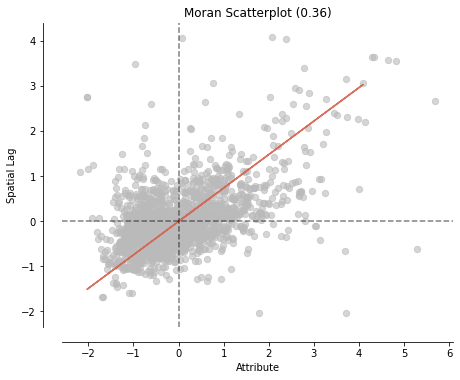

In [46]:
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
all_cities['residues'] = regression_model1.resid
# calculate weight matrix
w = weights.distance.DistanceBand.from_dataframe(OLS1, threshold = 250, ids='detid')
# some islands remove these
if bool(w.islands) == True:
            # there are islands remove and recalculate weights
            print ('Removing', len(w.islands), 'islands')
            for iterator in w.islands:
                OLS1 = OLS1[OLS1.detid != iterator]
            # with islands removed -> recalc weigths
            w = weights.distance.DistanceBand.from_dataframe(OLS1, threshold = 250, ids='detid')

mi = esda.Moran(OLS1['residues'], w)
print ("Moran's I is:",mi.I,' with a significance of:',mi.p_sim)
#all_cities.loc[all_cities['residues'].isna()]
moran_scatterplot(mi);

In [131]:
def linearity_check(x_train, y_train, residuals, predy_train):
    # create plot
    fig, ax = plt.subplots(1,3, figsize=(20,5))

    # create regresion between y and predicted y
    sns.regplot(predy_train, y_train, ax=ax[0])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    # create regression plot with residuals and predicted y
    sns.regplot(predy_train, residuals, ax=ax[1])
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')

    # create kde plot of residuals
    sns.distplot(residuals, ax=ax[2])
    ax[2].set_xlabel('Residuals')
    ax[2].set_ylabel('Density')

    fig.suptitle('Linearity test', fontsize=25)

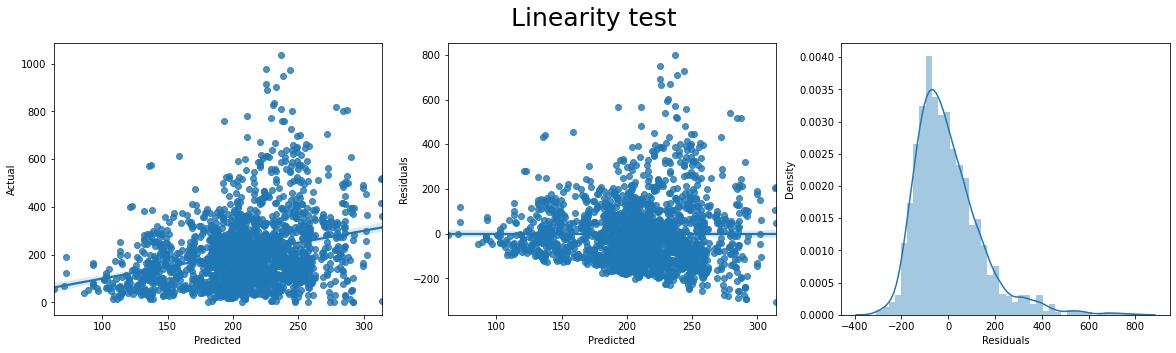

In [132]:
# residual analysis to determine whether assumption of linearity was correct
residuals1 = regression_model1.resid
predy_train1 = regression_model1.fittedvalues
#y_train1 = y_train1.reshape(y_train1.shape[0], )

linearity_check(x_train1, y_train1, residuals1, predy_train1)

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


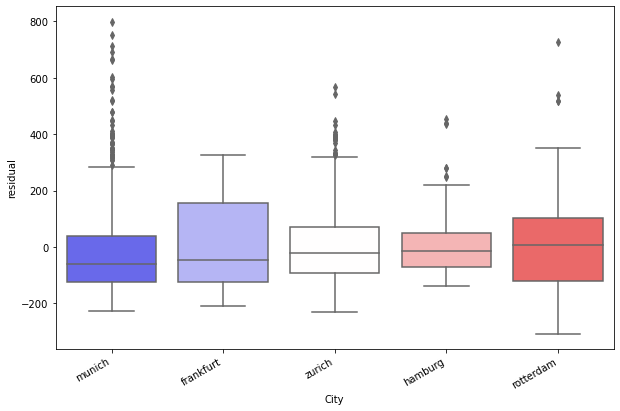

In [133]:
conditions = [
    x_train1['City_hamburg'] == 1, 
    x_train1['City_munich'] == 1, 
    x_train1['City_rotterdam'] == 1,
    x_train1['City_zurich']  == 1,
    x_train1['City_frankfurt'] == 1
]

outputs = [
    'hamburg', 'munich', 'rotterdam', 'zurich', 'frankfurt'
]



x_train_cities = x_train1[['station', 'cycleway', 'footway', 'pedestrian']]
x_train_cities['City'] = np.select(conditions, outputs, 'Other')
x_train_cities['residual'] = residuals1.values

medians = x_train_cities.groupby("City").residual.median().to_frame('city_residual')

f = plt.figure(figsize=(10,7))
ax = plt.gca()
sns.boxplot('City', 'residual', ax = ax,
                data=x_train_cities.merge(medians, how='left',
                              left_on='City',
                              right_index=True)
                   .sort_values('city_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

In [134]:
def get_teststats(y_test, predy_test):
    r2_score_test = r2_score(y_test, predy_test)
    MAE = mean_absolute_error(y_test, predy_test)
    mse = mean_squared_error(y_test, predy_test)
    rmse = sqrt(mse)
    return r2_score_test, MAE, rmse

In [135]:
R2score_model1, MAE_model1, rmse_model1 = get_teststats(y_test1, predy_test1)
print(f'R2-score 1: {R2score_model1}')
print(f'MAE 1:{MAE_model1}')
print(f'rmse 1: {rmse_model1}')

R2-score 1: 0.040635521638615946
MAE 1:107.91540833136604
rmse 1: 136.53718972439438


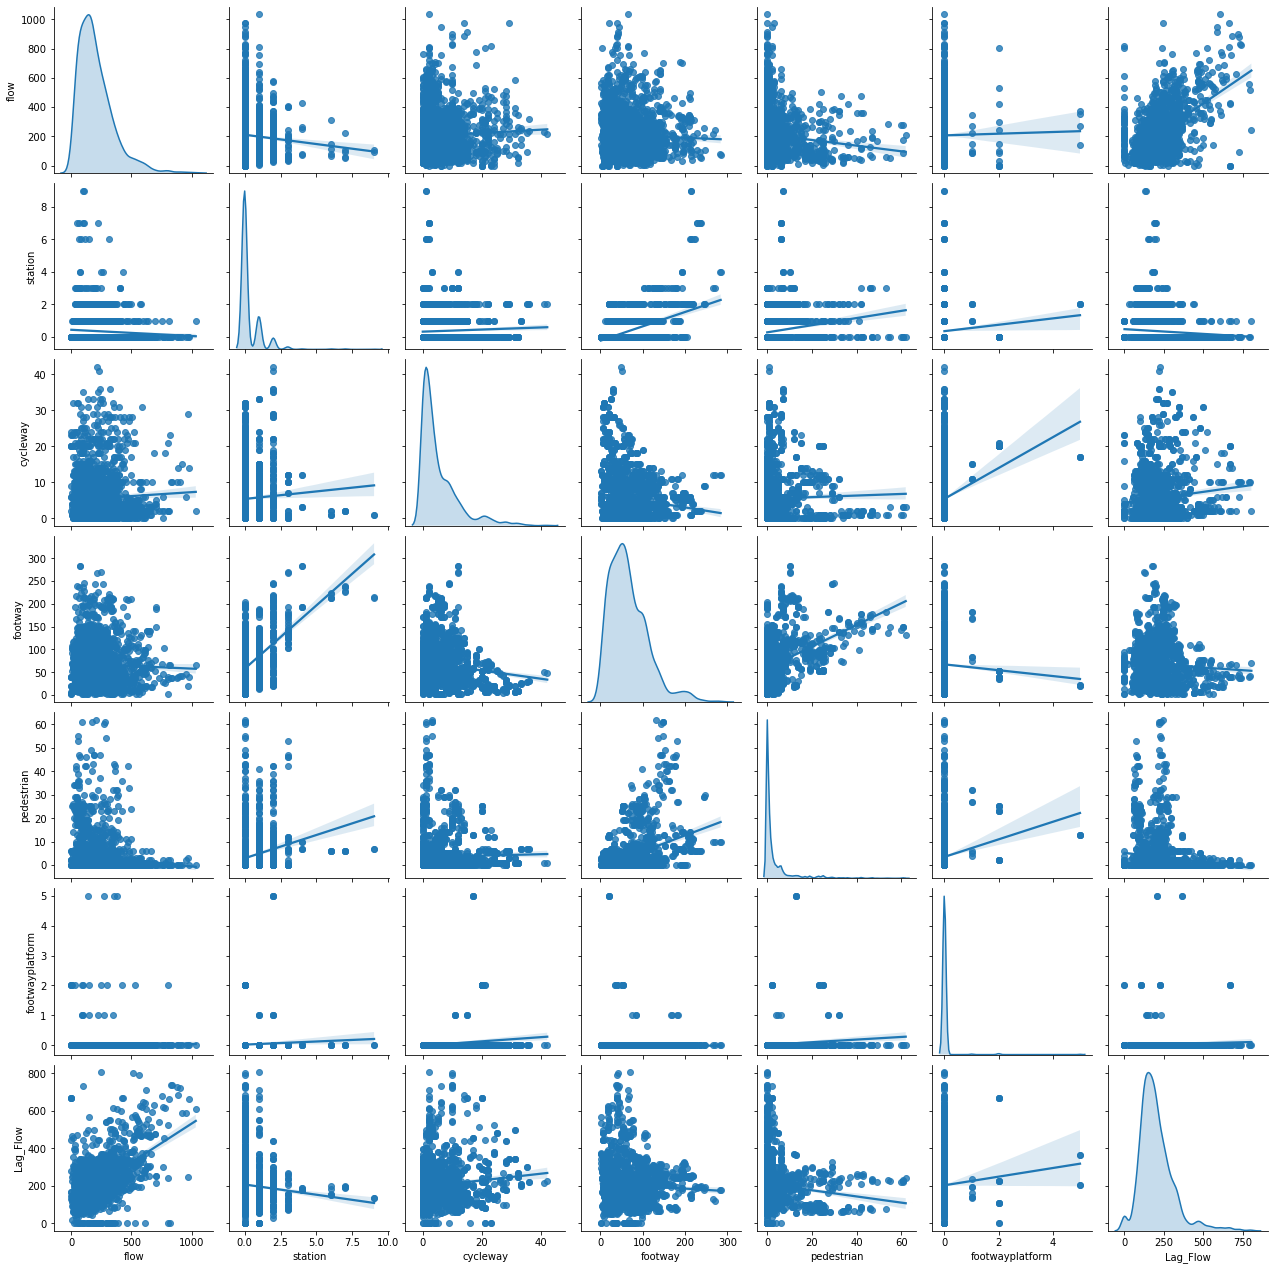

In [152]:
_ = sns.pairplot(all_cities[['flow', 'station', 'cycleway', 'footway', 'pedestrian', 'footwayplatform', 'Lag_Flow']], kind='reg', diag_kind='kde')

### Second iteration model

choices:
-create log of skewed variables
-remove footwayplatforms, since it's not very significant

In [137]:
all_cities['station_log'] = np.log(all_cities['station'].replace(0, np.nan))
all_cities['cycleway_log'] = np.log(all_cities['cycleway'].replace(0, np.nan))
all_cities['footway_log'] = np.log(all_cities['footway'].replace(0, np.nan))
all_cities['pedestrian_log'] = np.log(all_cities['pedestrian'].replace(0, np.nan))
all_cities['flow_log'] = np.log(all_cities['flow'].replace(0, np.nan))

# create second degree polynomial
polynomial_features= PolynomialFeatures(degree=2)
poly_constructionyear = polynomial_features.fit_transform(all_cities[['footway']])
all_cities['footway_2'] = pd.DataFrame(poly_constructionyear)[2].values

all_cities = all_cities.fillna(0)

In [138]:
#all_cities.head()

In [139]:
regression_model2, y_train2, x_train2, y_test2, x_test2, predy_test2\
= regression(['flow'], ['station', 'cycleway_log', 'footway', 'footway_2', 'pedestrian_log', 'City'], all_cities)

Shape of the training set is (1863, 17) and of the testing set is (466, 17).


In [140]:
print(regression_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     18.47
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           9.44e-30
Time:                        22:13:24   Log-Likelihood:                -11885.
No. Observations:                1863   AIC:                         2.379e+04
Df Residuals:                    1853   BIC:                         2.385e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            192.6792      8.326     23.

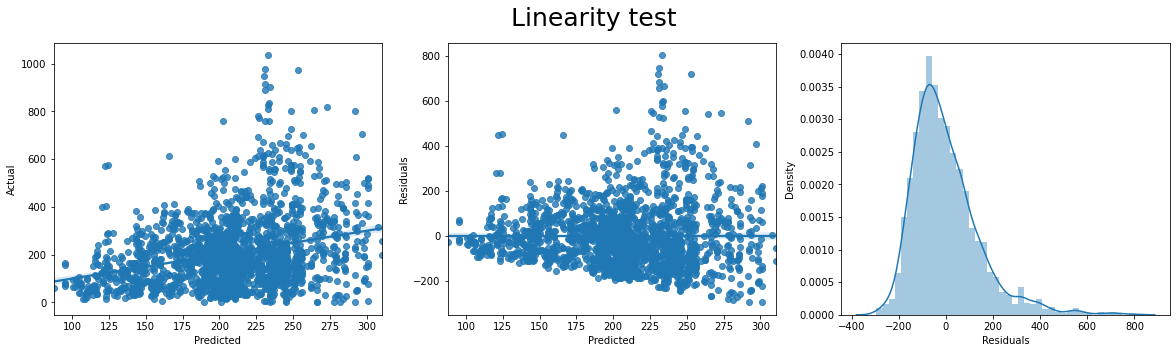

In [141]:
# residual analysis to determine whether assumption of linearity was correct
residuals2 = regression_model2.resid
predy_train2 = regression_model2.fittedvalues
#y_train2 = y_train2.reshape(y_train2.shape[0], )

linearity_check(x_train2, y_train2, residuals2, predy_train2)

In [142]:
R2score_model2, MAE_model2, rmse_model2 = get_teststats(y_test2, predy_test2)
print(f'R2-score 2: {R2score_model2}')
print(f'MAE 2:{MAE_model2}')
print(f'rmse 2: {rmse_model2}')


R2-score 2: 0.03921253224476562
MAE 2:108.19312559984249
rmse 2: 136.63841245281318


### Third iteration model

In [148]:
regression_model3, y_train3, x_train3, y_test3, x_test3, predy_test3\
= regression(['flow'], ['station', 'cycleway_log', 'footway', 'footway_2', 'pedestrian_log', 'City', 'Lag_Flow'], all_cities)

Shape of the training set is (1863, 17) and of the testing set is (466, 17).


In [149]:
print(regression_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     90.98
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          7.19e-153
Time:                        22:15:19   Log-Likelihood:                -11593.
No. Observations:                1863   AIC:                         2.321e+04
Df Residuals:                    1852   BIC:                         2.327e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             57.3571      8.804      6.

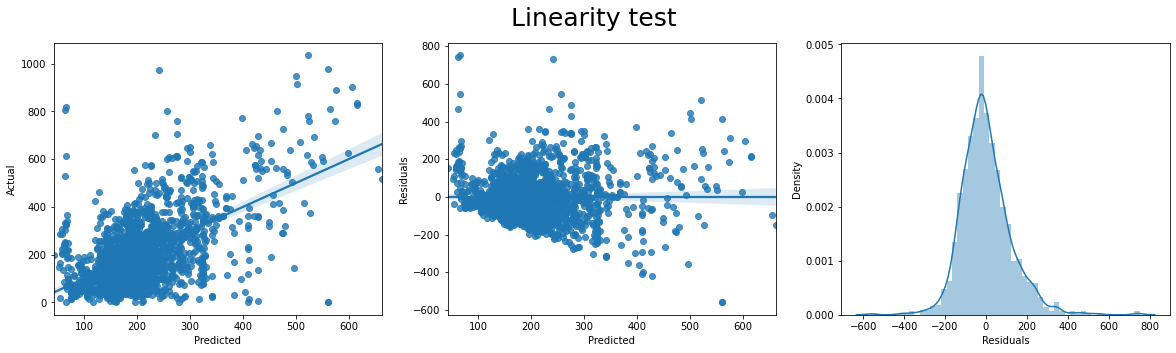

In [150]:
# residual analysis to determine whether assumption of linearity was correct
residuals3 = regression_model3.resid
predy_train3 = regression_model3.fittedvalues
#y_train3 = y_train3.reshape(y_train3.shape[0], )

linearity_check(x_train3, y_train3, residuals3, predy_train3)

In [153]:
R3score_model3, MAE_model3, rmse_model3 = get_teststats(y_test3, predy_test3)
print(f'R3-score 3: {R3score_model3}')
print(f'MAE 3:{MAE_model3}')
print(f'rmse 3: {rmse_model3}')


R3-score 3: 0.2122582827161439
MAE 3:92.14605739309215
rmse 3: 123.72317756856211


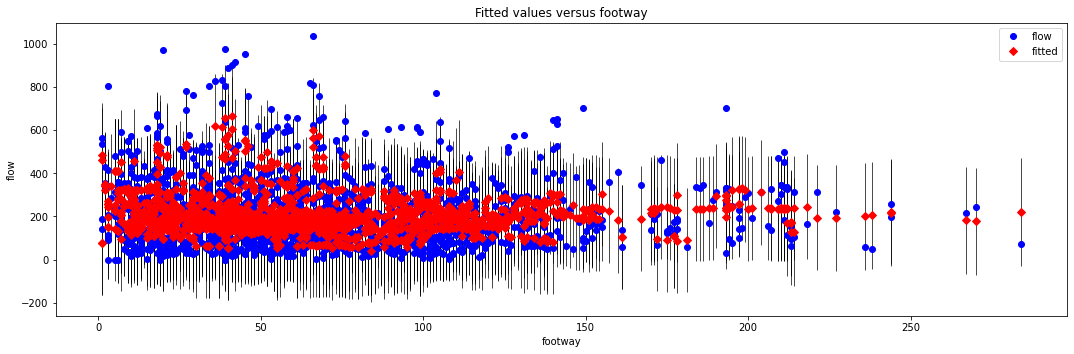

In [167]:
# was chosen on the x-axis since that showed the values the most clearly
fig, ax = plt.subplots(figsize = (15, 5))
fig = sm.graphics.plot_fit(regression_model2, 3, ax=ax)
fig.tight_layout(pad=1.0)

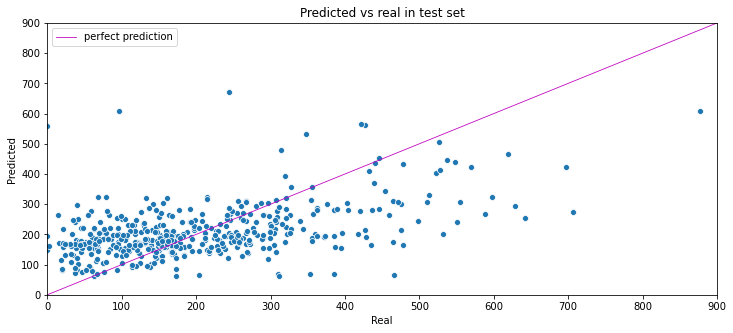

In [202]:
#y_test3 = y_test3.reshape(y_test3.shape[0], )

# create regresion between y and predicted y
fig, ax = plt.subplots(figsize = (12, 5))
test_scatter = sns.scatterplot(y_test3['flow'], predy_test3, ax=ax)

# create perfect prediction line
x1 = [0, 900]
y1 = [0, 900]
sns.lineplot(x1, y1, color = "m", linewidth = 0.8, label = 'perfect prediction')

ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
ax.set_title('Predicted vs real in test set')
ax.set_xlim([0,900])
ax.set_ylim([0,900])

plt.show()